Accuracy: 0.87


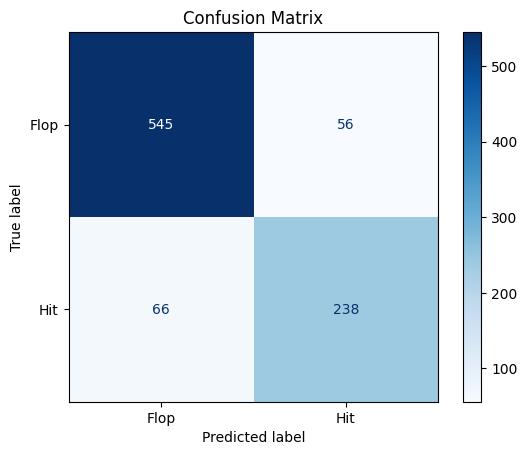

Model and feature columns saved.


In [ ]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Step 1: Load dataset
df = pd.read_csv('movie_metadata.csv')

# Step 2: Select meaningful pre-release features
df = df[['director_name', 'actor_1_name', 'actor_2_name', 'actor_3_name',
         'budget', 'genres', 'duration', 'title_year', 'imdb_score']]
df = df.dropna()
df = df[df['budget'] > 1000]  # remove garbage budgets

# Step 3: Define success label
df['success'] = (df['imdb_score'] >= 7.0).astype(int)

# Step 4: Cast size
df['cast_size'] = df[['actor_1_name', 'actor_2_name', 'actor_3_name']].nunique(axis=1)

# Step 5: Director fame (proxy: average rating of their previous movies)
director_avg = df.groupby('director_name')['imdb_score'].mean().to_dict()
df['director_fame'] = df['director_name'].map(director_avg)

# Step 6: One-hot encode genres (use first genre only)
df['main_genre'] = df['genres'].apply(lambda x: x.split('|')[0])
df = pd.get_dummies(df, columns=['main_genre'], prefix='genre')

# Step 7: Features and target
X = df[['budget', 'duration', 'title_year', 'cast_size', 'director_fame'] +
       [col for col in df.columns if col.startswith('genre_')]]
y = df['success']

# Step 8: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 9: Train model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Step 10: Evaluate
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.2f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Flop', 'Hit'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# Step 11: Save the model and feature columns
joblib.dump(model, 'movie_success_model.pkl')
joblib.dump(X.columns.tolist(), 'feature_columns.pkl')
print("Model and feature columns saved.")


In [ ]:
import xgboost as xgb
from sklearn.metrics import classification_report

# Convert to DMatrix format (optional, for XGBoost)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define and train the model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# Evaluate
y_pred = xgb_model.predict(X_test)
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Save model
joblib.dump(xgb_model, 'xgb_movie_success_model.pkl')


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:51:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.8552486187845304
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       601
           1       0.80      0.76      0.78       304

    accuracy                           0.86       905
   macro avg       0.84      0.83      0.84       905
weighted avg       0.85      0.86      0.85       905



['xgb_movie_success_model.pkl']

In [ ]:
from sklearn.linear_model import LogisticRegression

# Train model
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)

# Evaluate
y_pred = log_model.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# Save model
joblib.dump(log_model, 'logreg_movie_success_model.pkl')


Logistic Regression Accuracy: 0.6928176795580111
[[567  34]
 [244  60]]


['logreg_movie_success_model.pkl']